# Strain mapping with py4DSTEM

The code in this directory calculates and visualizes strain maps.

The procedure is divided into 7 steps, each in a single notebook:
1. Get probe template
2. **Get the Bragg disks**
3. Determine the diffraction shifts
4. Calculate lattice vectors
5. Refine lattice vectors
6. Calculate strain
7. Visualize strain maps

# Notebook 2: Get the Bragg disks

In this step the Bragg disks are located, as follows:

* For each diffraction pattern:
    * Cross correlate (or hybrid cross-phase correlate) the DP with the probe kernel
    * Get a first guess at Bragg disk positions by identifying positions and intensities of all local maxima
    * Filter out erroneous peaks by removing those too close together, in order of decreasing intensity
* Save Bragg disks list

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from time import time

from py4DSTEM.process.datastructure import PointList, PointListArray
from py4DSTEM.readwrite import FileBrowser, read, append

In [2]:
# Examine file contents

fp = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
browser = FileBrowser(fp)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    datacube                            DataCube            
   1    probe_kernel                        DiffractionSlice    


In [3]:
# Load data

dc = browser.get_dataobject('datacube')
probe_kernel = browser.get_dataobject('probe_kernel')
browser.close()

### Test parameters on a few diffraction patterns

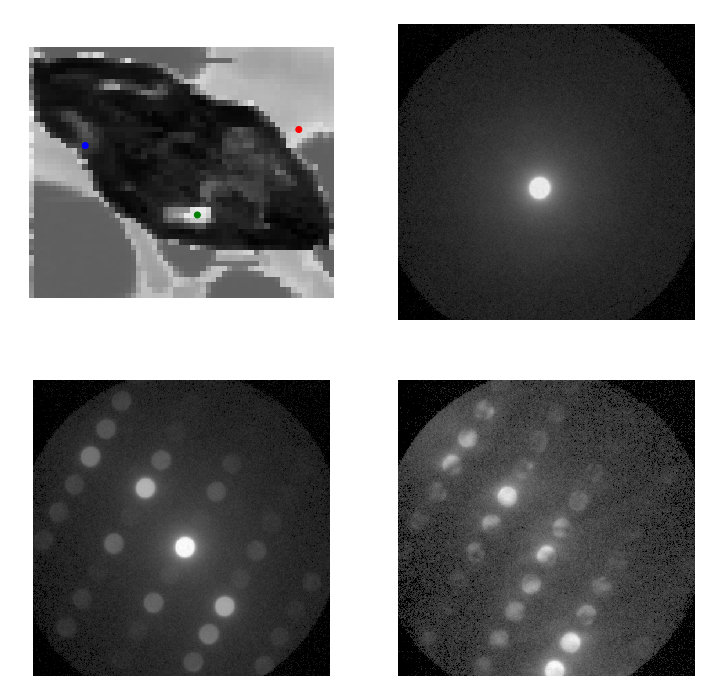

In [4]:
# Select and show 3 DPs

xs=(15,31,18)
ys=(50,31,10)
power=0.3

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))

ax11.matshow(np.average(dc.data4D,axis=(2,3)))
ax11.scatter(ys,xs,color=('r','g','b'))

ax12.matshow(dc.data4D[xs[0],ys[0],:,:]**power)
ax21.matshow(dc.data4D[xs[1],ys[1],:,:]**power)
ax22.matshow(dc.data4D[xs[2],ys[2],:,:]**power)

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()

In [5]:
# Select parameters
# Find Bragg disks in selected DPs

corrPower = 0.9
sigma_gaussianFilter = 2
edge_boundary = 20
maxNumPeaks = 100
minPeakSpacing = 40
minRelativeIntensity = 0.00001

coords = [('qx',float),('qy',float),('intensity',float)]
testBraggpeaks = []
for i in range(len(xs)):
    testBraggpeaks.append(PointList(coordinates=coords, parentDataCube=dc, name="test_Bragg_disks_xy={}_{}".format(xs[i],ys[i])))

t0=time()
probe_kernel_FT = np.conj(np.fft.fft2(probe_kernel.data2D))
for ind in range(len(xs)):
    Rx,Ry = xs[ind],ys[ind]
    print("Analyzing scan position {},{}".format(Rx,Ry))

    # Get diffraction pattern
    DP = dc.data4D[Rx,Ry,:,:]

    # Cross correlation     
    cc = py4DSTEM.process.utils.get_cross_correlation_fk(DP,probe_kernel_FT,corrPower)

    # Gaussian smoothing
    cc = np.maximum(cc,0)
    cc = gaussian_filter(cc, sigma_gaussianFilter)

    # Get maximal points
    max_points = py4DSTEM.process.utils.get_maximal_points(cc)

    # Remove points at edges
    max_points[:edge_boundary,:]=False
    max_points[-edge_boundary:,:]=False
    max_points[:,:edge_boundary]=False
    max_points[:,-edge_boundary:]=False    

    # Make point_list with structured array datatype ('rx','ry','qx','qy','intensity')
    point_list = testBraggpeaks[ind]

    max_point_indices_x, max_point_indices_y = np.nonzero(max_points)
    point_intensities = cc[max_point_indices_x,max_point_indices_y]

    length = len(point_intensities)
    for i in range(length):
        new_point = (max_point_indices_x[i],max_point_indices_y[i],point_intensities[i])
        point_list.add_point(new_point)

    # Order point list, keep only up to maxNumPeaks
    numPeaks = min(maxNumPeaks,length)
    point_list.sort(coordinate='intensity',order='descending')
    deletePeaks = np.zeros(point_list.length, bool)
    deletePeaks[numPeaks:] = True
    point_list.remove_points(deletePeaks)         

    # Remove peaks that are too close together
    r2 = minPeakSpacing**2
    deletePeaks = np.zeros(numPeaks,dtype=bool)
    for i in range(numPeaks):
        if deletePeaks[i] == False:
            tooClose = ( (point_list.data['qx']-point_list.data['qx'][i])**2 + \
                      (point_list.data['qy']-point_list.data['qy'][i])**2 ) < r2
            tooClose[:i+1] = False
            deletePeaks[tooClose] = True
    point_list.remove_points(deletePeaks)
    
    # Remove peaks below minRelativeIntensity threshold
    deletemask = point_list.data['intensity']/max(point_list.data['intensity']) < minRelativeIntensity
    point_list.remove_points(deletemask)
            
t=time()-t0
print("Finished in {}h {}m {}s".format(int(t/3600),int(t/60),int(t%60)))

Analyzing scan position 15,50
Analyzing scan position 31,31
Analyzing scan position 18,10
Finished in 0h 0m 0s


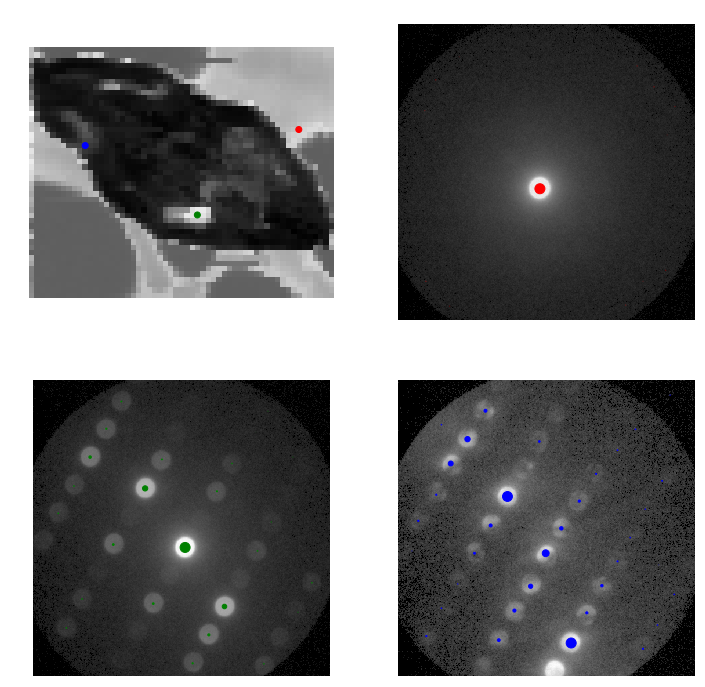

In [6]:
# Show results

power=0.3

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))

ax11.matshow(np.average(dc.data4D,axis=(2,3)))
ax11.scatter(ys,xs,color=('r','g','b'))

ax12.matshow(dc.data4D[xs[0],ys[0],:,:]**power)
ax21.matshow(dc.data4D[xs[1],ys[1],:,:]**power)
ax22.matshow(dc.data4D[xs[2],ys[2],:,:]**power)

peaks0 = testBraggpeaks[0]
peaks1 = testBraggpeaks[1]
peaks2 = testBraggpeaks[2]

ax12.scatter(peaks0.data['qy'],peaks0.data['qx'],color='r',s=100*peaks0.data['intensity']/np.max(peaks0.data['intensity']))
ax21.scatter(peaks1.data['qy'],peaks1.data['qx'],color='g',s=100*peaks1.data['intensity']/np.max(peaks1.data['intensity']))
ax22.scatter(peaks2.data['qy'],peaks2.data['qx'],color='b',s=100*peaks2.data['intensity']/np.max(peaks2.data['intensity']))

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()

### Loop through DPs, finding all Bragg disks

In [7]:
corrPower = 0.9
sigma_gaussianFilter = 2
edge_boundary = 20
maxNumPeaks = 100
minPeakSpacing = 40
minRelativeIntensity = 0.00001

coords = [('qx',float),('qy',float),('intensity',float)]
Braggpeak_pointlistarray = PointListArray(coordinates=coords, shape=(dc.R_Nx, dc.R_Ny), name="Bragg_disks")

t0=time()
probe_kernel_FT = np.conj(np.fft.fft2(probe_kernel.data2D))
for Rx in range(dc.R_Nx):
     for Ry in range(dc.R_Ny):
        print("Analyzing scan position {},{}".format(Rx,Ry))

        # Get diffraction pattern
        DP = dc.data4D[Rx,Ry,:,:]
        
        # Cross correlation     
        cc = py4DSTEM.process.utils.get_cross_correlation_fk(DP,probe_kernel_FT,corrPower)

        # Gaussian smoothing
        cc = np.maximum(cc,0)
        cc = gaussian_filter(cc, sigma_gaussianFilter)
        
        # Get maximal points
        max_points = py4DSTEM.process.utils.get_maximal_points(cc)
        
        # Remove points at edges
        max_points[:edge_boundary,:]=False
        max_points[-edge_boundary:,:]=False
        max_points[:,:edge_boundary]=False
        max_points[:,-edge_boundary:]=False    
       
        # Make point_list with structured array datatype ('rx','ry','qx','qy','intensity')
        point_list = Braggpeak_pointlistarray.get_pointlist(Rx,Ry)

        max_point_indices_x, max_point_indices_y = np.nonzero(max_points)
        point_intensities = cc[max_point_indices_x,max_point_indices_y]

        length = len(point_intensities)
        for i in range(length):
            new_point = (max_point_indices_x[i],max_point_indices_y[i],point_intensities[i])
            point_list.add_point(new_point)
        
        # Order point list, keep only up to maxNumPeaks
        numPeaks = min(maxNumPeaks,length)
        point_list.sort(coordinate='intensity',order='descending')
        deletePeaks = np.zeros(point_list.length, bool)
        deletePeaks[numPeaks:] = True
        point_list.remove_points(deletePeaks)         

        # Remove peaks that are too close together
        r2 = minPeakSpacing**2
        deletePeaks = np.zeros(numPeaks,dtype=bool)
        for i in range(numPeaks):
            if deletePeaks[i] == False:
                tooClose = ( (point_list.data['qx']-point_list.data['qx'][i])**2 + \
                          (point_list.data['qy']-point_list.data['qy'][i])**2 ) < r2
                tooClose[:i+1] = False
                deletePeaks[tooClose] = True
        point_list.remove_points(deletePeaks)
            
t=time()-t0
print("Finished in {}h {}m {}s".format(int(t/3600),int(t/60),int(t%60)))

Analyzing scan position 0,0
Analyzing scan position 0,1
Analyzing scan position 0,2
Analyzing scan position 0,3
Analyzing scan position 0,4
Analyzing scan position 0,5
Analyzing scan position 0,6
Analyzing scan position 0,7
Analyzing scan position 0,8
Analyzing scan position 0,9
Analyzing scan position 0,10
Analyzing scan position 0,11
Analyzing scan position 0,12
Analyzing scan position 0,13
Analyzing scan position 0,14
Analyzing scan position 0,15
Analyzing scan position 0,16
Analyzing scan position 0,17
Analyzing scan position 0,18
Analyzing scan position 0,19
Analyzing scan position 0,20
Analyzing scan position 0,21
Analyzing scan position 0,22
Analyzing scan position 0,23
Analyzing scan position 0,24
Analyzing scan position 0,25
Analyzing scan position 0,26
Analyzing scan position 0,27
Analyzing scan position 0,28
Analyzing scan position 0,29
Analyzing scan position 0,30
Analyzing scan position 0,31
Analyzing scan position 0,32
Analyzing scan position 0,33
Analyzing scan position 

Analyzing scan position 5,2
Analyzing scan position 5,3
Analyzing scan position 5,4
Analyzing scan position 5,5
Analyzing scan position 5,6
Analyzing scan position 5,7
Analyzing scan position 5,8
Analyzing scan position 5,9
Analyzing scan position 5,10
Analyzing scan position 5,11
Analyzing scan position 5,12
Analyzing scan position 5,13
Analyzing scan position 5,14
Analyzing scan position 5,15
Analyzing scan position 5,16
Analyzing scan position 5,17
Analyzing scan position 5,18
Analyzing scan position 5,19
Analyzing scan position 5,20
Analyzing scan position 5,21
Analyzing scan position 5,22
Analyzing scan position 5,23
Analyzing scan position 5,24
Analyzing scan position 5,25
Analyzing scan position 5,26
Analyzing scan position 5,27
Analyzing scan position 5,28
Analyzing scan position 5,29
Analyzing scan position 5,30
Analyzing scan position 5,31
Analyzing scan position 5,32
Analyzing scan position 5,33
Analyzing scan position 5,34
Analyzing scan position 5,35
Analyzing scan positio

Analyzing scan position 10,5
Analyzing scan position 10,6
Analyzing scan position 10,7
Analyzing scan position 10,8
Analyzing scan position 10,9
Analyzing scan position 10,10
Analyzing scan position 10,11
Analyzing scan position 10,12
Analyzing scan position 10,13
Analyzing scan position 10,14
Analyzing scan position 10,15
Analyzing scan position 10,16
Analyzing scan position 10,17
Analyzing scan position 10,18
Analyzing scan position 10,19
Analyzing scan position 10,20
Analyzing scan position 10,21
Analyzing scan position 10,22
Analyzing scan position 10,23
Analyzing scan position 10,24
Analyzing scan position 10,25
Analyzing scan position 10,26
Analyzing scan position 10,27
Analyzing scan position 10,28
Analyzing scan position 10,29
Analyzing scan position 10,30
Analyzing scan position 10,31
Analyzing scan position 10,32
Analyzing scan position 10,33
Analyzing scan position 10,34
Analyzing scan position 10,35
Analyzing scan position 10,36
Analyzing scan position 10,37
Analyzing scan 

Analyzing scan position 14,52
Analyzing scan position 14,53
Analyzing scan position 14,54
Analyzing scan position 14,55
Analyzing scan position 14,56
Analyzing scan position 15,0
Analyzing scan position 15,1
Analyzing scan position 15,2
Analyzing scan position 15,3
Analyzing scan position 15,4
Analyzing scan position 15,5
Analyzing scan position 15,6
Analyzing scan position 15,7
Analyzing scan position 15,8
Analyzing scan position 15,9
Analyzing scan position 15,10
Analyzing scan position 15,11
Analyzing scan position 15,12
Analyzing scan position 15,13
Analyzing scan position 15,14
Analyzing scan position 15,15
Analyzing scan position 15,16
Analyzing scan position 15,17
Analyzing scan position 15,18
Analyzing scan position 15,19
Analyzing scan position 15,20
Analyzing scan position 15,21
Analyzing scan position 15,22
Analyzing scan position 15,23
Analyzing scan position 15,24
Analyzing scan position 15,25
Analyzing scan position 15,26
Analyzing scan position 15,27
Analyzing scan posit

Analyzing scan position 19,43
Analyzing scan position 19,44
Analyzing scan position 19,45
Analyzing scan position 19,46
Analyzing scan position 19,47
Analyzing scan position 19,48
Analyzing scan position 19,49
Analyzing scan position 19,50
Analyzing scan position 19,51
Analyzing scan position 19,52
Analyzing scan position 19,53
Analyzing scan position 19,54
Analyzing scan position 19,55
Analyzing scan position 19,56
Analyzing scan position 20,0
Analyzing scan position 20,1
Analyzing scan position 20,2
Analyzing scan position 20,3
Analyzing scan position 20,4
Analyzing scan position 20,5
Analyzing scan position 20,6
Analyzing scan position 20,7
Analyzing scan position 20,8
Analyzing scan position 20,9
Analyzing scan position 20,10
Analyzing scan position 20,11
Analyzing scan position 20,12
Analyzing scan position 20,13
Analyzing scan position 20,14
Analyzing scan position 20,15
Analyzing scan position 20,16
Analyzing scan position 20,17
Analyzing scan position 20,18
Analyzing scan posit

Analyzing scan position 24,34
Analyzing scan position 24,35
Analyzing scan position 24,36
Analyzing scan position 24,37
Analyzing scan position 24,38
Analyzing scan position 24,39
Analyzing scan position 24,40
Analyzing scan position 24,41
Analyzing scan position 24,42
Analyzing scan position 24,43
Analyzing scan position 24,44
Analyzing scan position 24,45
Analyzing scan position 24,46
Analyzing scan position 24,47
Analyzing scan position 24,48
Analyzing scan position 24,49
Analyzing scan position 24,50
Analyzing scan position 24,51
Analyzing scan position 24,52
Analyzing scan position 24,53
Analyzing scan position 24,54
Analyzing scan position 24,55
Analyzing scan position 24,56
Analyzing scan position 25,0
Analyzing scan position 25,1
Analyzing scan position 25,2
Analyzing scan position 25,3
Analyzing scan position 25,4
Analyzing scan position 25,5
Analyzing scan position 25,6
Analyzing scan position 25,7
Analyzing scan position 25,8
Analyzing scan position 25,9
Analyzing scan posit

Analyzing scan position 29,25
Analyzing scan position 29,26
Analyzing scan position 29,27
Analyzing scan position 29,28
Analyzing scan position 29,29
Analyzing scan position 29,30
Analyzing scan position 29,31
Analyzing scan position 29,32
Analyzing scan position 29,33
Analyzing scan position 29,34
Analyzing scan position 29,35
Analyzing scan position 29,36
Analyzing scan position 29,37
Analyzing scan position 29,38
Analyzing scan position 29,39
Analyzing scan position 29,40
Analyzing scan position 29,41
Analyzing scan position 29,42
Analyzing scan position 29,43
Analyzing scan position 29,44
Analyzing scan position 29,45
Analyzing scan position 29,46
Analyzing scan position 29,47
Analyzing scan position 29,48
Analyzing scan position 29,49
Analyzing scan position 29,50
Analyzing scan position 29,51
Analyzing scan position 29,52
Analyzing scan position 29,53
Analyzing scan position 29,54
Analyzing scan position 29,55
Analyzing scan position 29,56
Analyzing scan position 30,0
Analyzing s

Analyzing scan position 34,16
Analyzing scan position 34,17
Analyzing scan position 34,18
Analyzing scan position 34,19
Analyzing scan position 34,20
Analyzing scan position 34,21
Analyzing scan position 34,22
Analyzing scan position 34,23
Analyzing scan position 34,24
Analyzing scan position 34,25
Analyzing scan position 34,26
Analyzing scan position 34,27
Analyzing scan position 34,28
Analyzing scan position 34,29
Analyzing scan position 34,30
Analyzing scan position 34,31
Analyzing scan position 34,32
Analyzing scan position 34,33
Analyzing scan position 34,34
Analyzing scan position 34,35
Analyzing scan position 34,36
Analyzing scan position 34,37
Analyzing scan position 34,38
Analyzing scan position 34,39
Analyzing scan position 34,40
Analyzing scan position 34,41
Analyzing scan position 34,42
Analyzing scan position 34,43
Analyzing scan position 34,44
Analyzing scan position 34,45
Analyzing scan position 34,46
Analyzing scan position 34,47
Analyzing scan position 34,48
Analyzing 

Analyzing scan position 39,7
Analyzing scan position 39,8
Analyzing scan position 39,9
Analyzing scan position 39,10
Analyzing scan position 39,11
Analyzing scan position 39,12
Analyzing scan position 39,13
Analyzing scan position 39,14
Analyzing scan position 39,15
Analyzing scan position 39,16
Analyzing scan position 39,17
Analyzing scan position 39,18
Analyzing scan position 39,19
Analyzing scan position 39,20
Analyzing scan position 39,21
Analyzing scan position 39,22
Analyzing scan position 39,23
Analyzing scan position 39,24
Analyzing scan position 39,25
Analyzing scan position 39,26
Analyzing scan position 39,27
Analyzing scan position 39,28
Analyzing scan position 39,29
Analyzing scan position 39,30
Analyzing scan position 39,31
Analyzing scan position 39,32
Analyzing scan position 39,33
Analyzing scan position 39,34
Analyzing scan position 39,35
Analyzing scan position 39,36
Analyzing scan position 39,37
Analyzing scan position 39,38
Analyzing scan position 39,39
Analyzing sca

Analyzing scan position 43,55
Analyzing scan position 43,56
Analyzing scan position 44,0
Analyzing scan position 44,1
Analyzing scan position 44,2
Analyzing scan position 44,3
Analyzing scan position 44,4
Analyzing scan position 44,5
Analyzing scan position 44,6
Analyzing scan position 44,7
Analyzing scan position 44,8
Analyzing scan position 44,9
Analyzing scan position 44,10
Analyzing scan position 44,11
Analyzing scan position 44,12
Analyzing scan position 44,13
Analyzing scan position 44,14
Analyzing scan position 44,15
Analyzing scan position 44,16
Analyzing scan position 44,17
Analyzing scan position 44,18
Analyzing scan position 44,19
Analyzing scan position 44,20
Analyzing scan position 44,21
Analyzing scan position 44,22
Analyzing scan position 44,23
Analyzing scan position 44,24
Analyzing scan position 44,25
Analyzing scan position 44,26
Analyzing scan position 44,27
Analyzing scan position 44,28
Analyzing scan position 44,29
Analyzing scan position 44,30
Analyzing scan posit

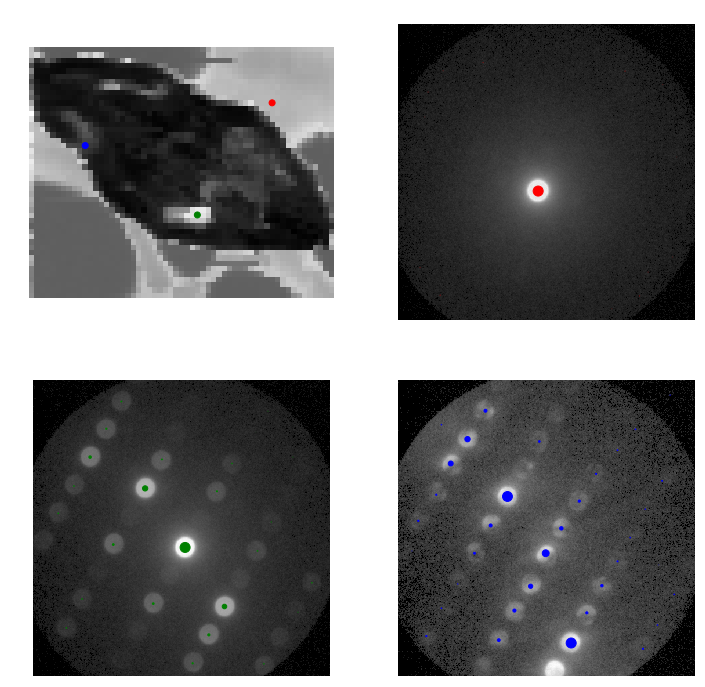

In [8]:
# Show results for a few DPs

xs=(10,31,18)
ys=(45,31,10)
power=0.3

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))

ax11.matshow(np.average(dc.data4D,axis=(2,3)))
ax11.scatter(ys,xs,color=('r','g','b'))

ax12.matshow(dc.data4D[xs[0],ys[0],:,:]**power)
ax21.matshow(dc.data4D[xs[1],ys[1],:,:]**power)
ax22.matshow(dc.data4D[xs[2],ys[2],:,:]**power)

peaks0 = Braggpeak_pointlistarray.get_pointlist(xs[0],ys[0])
peaks1 = Braggpeak_pointlistarray.get_pointlist(xs[1],ys[1])
peaks2 = Braggpeak_pointlistarray.get_pointlist(xs[2],ys[2])

ax12.scatter(peaks0.data['qy'],peaks0.data['qx'],color='r',s=100*peaks0.data['intensity']/np.max(peaks0.data['intensity']))
ax21.scatter(peaks1.data['qy'],peaks1.data['qx'],color='g',s=100*peaks1.data['intensity']/np.max(peaks1.data['intensity']))
ax22.scatter(peaks2.data['qy'],peaks2.data['qx'],color='b',s=100*peaks2.data['intensity']/np.max(peaks2.data['intensity']))

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()

In [9]:
# Copy Bragg peaks pointlistarray, to further threshold detected peaks

Braggpeak_pointlistarray_refined = Braggpeak_pointlistarray.copy(name='Braggpeaks')

In [10]:
# Remove points based on new peak spacing or minimum relative intensity thresholds

maxNumPeaks = 60
minPeakSpacing = 50
minRelativeIntensity = 0.0005

for Rx in range(dc.R_Nx):
     for Ry in range(dc.R_Ny):

        point_list = Braggpeak_pointlistarray_refined.get_pointlist(Rx,Ry)

        # Order point list, keep only up to maxNumPeaks
        numPeaks = min(maxNumPeaks,point_list.length)
        point_list.sort(coordinate='intensity',order='descending')
        deletePeaks = np.zeros(point_list.length, bool)
        deletePeaks[numPeaks:] = True
        point_list.remove_points(deletePeaks) 
        
        # Remove peaks that are too close together
        point_list.sort(coordinate='intensity',order='descending')
        numPeaks = min(maxNumPeaks,point_list.length)
        r2 = minPeakSpacing**2
        deletePeaks = np.zeros(numPeaks,dtype=bool)
        for i in range(numPeaks):
            if deletePeaks[i] == False:
                tooClose = ( (point_list.data['qx']-point_list.data['qx'][i])**2 + \
                          (point_list.data['qy']-point_list.data['qy'][i])**2 ) < r2
                tooClose[:i+1] = False
                deletePeaks[tooClose] = True
        point_list.remove_points(deletePeaks)
        
        # Remove peaks below minRelativeIntensity threshold
        deletemask = point_list.data['intensity']/max(point_list.data['intensity']) < minRelativeIntensity
        point_list.remove_points(deletemask)

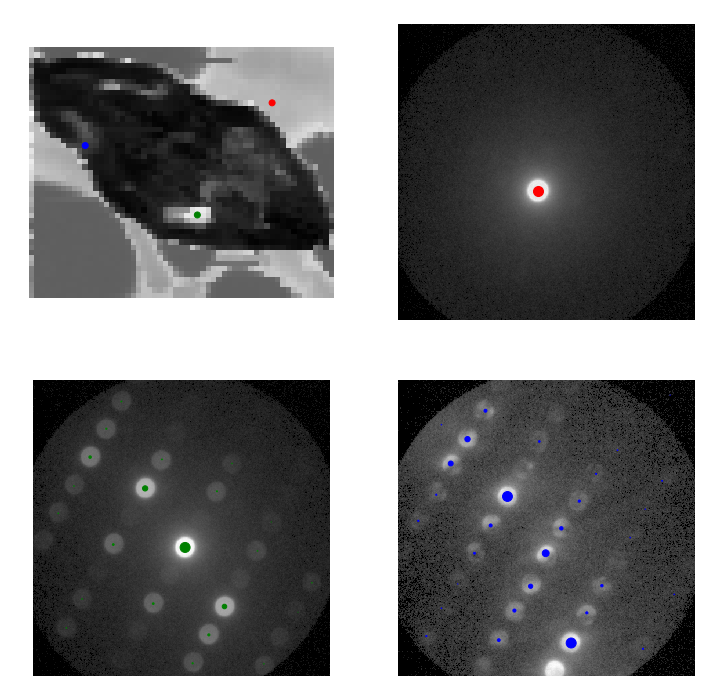

In [11]:
# Show newly thresholded results for a few DPs

xs=(10,31,18)
ys=(45,31,10)
power=0.3

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))

ax11.matshow(np.average(dc.data4D,axis=(2,3)))
ax11.scatter(ys,xs,color=('r','g','b'))

ax12.matshow(dc.data4D[xs[0],ys[0],:,:]**power)
ax21.matshow(dc.data4D[xs[1],ys[1],:,:]**power)
ax22.matshow(dc.data4D[xs[2],ys[2],:,:]**power)

peaks0 = Braggpeak_pointlistarray_refined.get_pointlist(xs[0],ys[0])
peaks1 = Braggpeak_pointlistarray_refined.get_pointlist(xs[1],ys[1])
peaks2 = Braggpeak_pointlistarray_refined.get_pointlist(xs[2],ys[2])

ax12.scatter(peaks0.data['qy'],peaks0.data['qx'],color='r',s=100*peaks0.data['intensity']/np.max(peaks0.data['intensity']))
ax21.scatter(peaks1.data['qy'],peaks1.data['qx'],color='g',s=100*peaks1.data['intensity']/np.max(peaks1.data['intensity']))
ax22.scatter(peaks2.data['qy'],peaks2.data['qx'],color='b',s=100*peaks2.data['intensity']/np.max(peaks2.data['intensity']))

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()

### Save Bragg disk list

In [12]:
# Append to processing file

fp = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
append(Braggpeak_pointlistarray_refined, fp)

Opening file /home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5...
Done.
